## Goal : Extract the evolution of the number of toggles per project

Import

In [16]:
import os
import regex as re
import datetime
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.base import BaseEstimator, RegressorMixin
import matplotlib.pyplot as plt
import matplotlib.patches as pat
import matplotlib.lines as mlines
from matplotlib.ticker import ScalarFormatter
import matplotlib.patheffects as pe
import json

### Now we can plot the number of feature toggles

In [4]:
months = dict()

writen_monthes = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

for index_month in range(len(writen_monthes)):
    months[writen_monthes[index_month]] = index_month+1

# 1. we count the number of FT

def extract_nb_ft(file_path, exp):
    # input : a file path to a version of the feature toggle file
    # output : the number of feature toggles in the file
    with open(file_path, 'r') as f:
        m = re.findall(exp, f.read())
    return len(m)

# 2. we extract the date (usable as timestamp)

def extract_date(file_path):
    # input : the path of the file 
    # e.g. 0001.26-Oct-2021.46c1c24b48572d74fb582e1e5a62552c39409685.featureflag.go
    # output : the date "26-Oct-2021"
    return file_path.split(".")[2]

def extract_stamp(kf):
    # input : the path of the file 
    # e.g. 0001.26-Oct-2021.46c1c24b48572d74fb582e1e5a62552c39409685.featureflag.go
    # output : a timestamp
    d = extract_date(kf).split('-')
    # class datetime.date(year, month, day)
    return datetime.date(int(d[2]), months[d[1]], int(d[0]))

def get_dates_and_fts(system_name, exp):

    data_dir =  "./data/"+system_name+"_ft_changes/"

    files = [data_dir+k for k in os.listdir(data_dir)]
    
    df_ft = pd.DataFrame([[extract_stamp(kf) for kf in files], 
                      [extract_nb_ft(kf, exp) for kf in files]]).dropna().transpose()
    
    df_ft.columns = ["date", "ft"]
    
    df_ft = df_ft.sort_values(by=["date"])
    
    return df_ft

res = dict()
res['boulder'] = get_dates_and_fts('boulder', "\n[a-zA-Z]*\n")
res['juju'] = get_dates_and_fts('juju', "const (.*) =")
res['kops'] = get_dates_and_fts('kops', "[N|n]ew.*,*Bool*")
res['kubernetes'] = get_dates_and_fts('kubernetes', "=")
res['loomchain'] = get_dates_and_fts('loomchain', "=")

In [5]:
keys = [k for k in res.keys()]

for key in keys:
    res[key].to_csv("./results/nb_fts/"+key+"2.csv")

In [6]:
class KernelRegression(BaseEstimator, RegressorMixin):
    """Nadaraya-Watson kernel regression with automatic bandwidth selection.
    This implements Nadaraya-Watson kernel regression with (optional) automatic
    bandwith selection of the kernel via leave-one-out cross-validation. Kernel
    regression is a simple non-parametric kernelized technique for learning
    a non-linear relationship between input variable(s) and a target variable.
    Parameters
    ----------
    kernel : string or callable, default="rbf"
        Kernel map to be approximated. A callable should accept two arguments
        and the keyword arguments passed to this object as kernel_params, and
        should return a floating point number.
    gamma : float, default=None
        Gamma parameter for the RBF ("bandwidth"), polynomial,
        exponential chi2 and sigmoid kernels. Interpretation of the default
        value is left to the kernel; see the documentation for
        sklearn.metrics.pairwise. Ignored by other kernels. If a sequence of
        values is given, one of these values is selected which minimizes
        the mean-squared-error of leave-one-out cross-validation.
    See also
    --------
    sklearn.metrics.pairwise.kernel_metrics : List of built-in kernels.
    """

    def __init__(self, kernel="rbf", gamma=None):
        self.kernel = kernel
        self.gamma = gamma

    def fit(self, X, y):
        """Fit the model
        Parameters
        ----------
        X : array-like of shape = [n_samples, n_features]
            The training input samples.
        y : array-like, shape = [n_samples]
            The target values
        Returns
        -------
        self : object
            Returns self.
        """
        self.X = X
        self.y = y

        if hasattr(self.gamma, "__iter__"):
            self.gamma = self._optimize_gamma(self.gamma)

        return self

    def predict(self, X):
        """Predict target values for X.
        Parameters
        ----------
        X : array-like of shape = [n_samples, n_features]
            The input samples.
        Returns
        -------
        y : array of shape = [n_samples]
            The predicted target value.
        """
        K = pairwise_kernels(self.X, X, metric=self.kernel, gamma=self.gamma)
        return (K * self.y[:, None]).sum(axis=0) / K.sum(axis=0)

    def _optimize_gamma(self, gamma_values):
        # Select specific value of gamma from the range of given gamma_values
        # by minimizing mean-squared error in leave-one-out cross validation
        mse = np.empty_like(gamma_values, dtype=np.float)
        for i, gamma in enumerate(gamma_values):
            K = pairwise_kernels(self.X, self.X, metric=self.kernel,
                                 gamma=gamma)
            np.fill_diagonal(K, 0)  # leave-one-out
            Ky = K * self.y[:, np.newaxis]
            y_pred = Ky.sum(axis=0) / K.sum(axis=0)
            mse[i] = ((y_pred - self.y) ** 2).mean()
            return gamma_values[np.nanargmin(mse)]

for key in keys:
    res[key].to_csv("./results/nb_fts/"+key+"2.csv")

def get_estimation(system_name):
    
    df = res[system_name]
    
    k = KernelRegression(kernel="rbf")
    
    initial_date = datetime.datetime.toordinal(df.date[0])
    
    ordinal_dates = df.date.map(datetime.datetime.toordinal)
    
    k.fit(np.array([(i-initial_date)/100 for i in ordinal_dates]).reshape(-1,1), df.ft)
    
    min_year = int(str(sorted(df.date)[0])[0:4])
    min_month = int(str(sorted(df.date)[0])[5:7])
    max_year = int(str(sorted(df.date)[df.shape[0]-1])[0:4])
    max_month = int(str(sorted(df.date)[df.shape[0]-1])[5:7])
    
    extended_dates = []
    for i in range(min_year, max_year+1):
        if i == min_year:
            for j in range(min_month, 13):
                extended_dates.append(datetime.date(i, j, 1))
        elif i == max_year:
            for j in range(1, max_month):
                extended_dates.append(datetime.date(i, j, 1))
        else:
            for j in range(1, 13):
                extended_dates.append(datetime.date(i, j, 1))
    
    predictions = k.predict(np.array([(i-initial_date)/100
                        for i in pd.Series(extended_dates).map(datetime.datetime.toordinal)]).reshape(-1,1))
    
    df_est = pd.DataFrame([extended_dates, predictions]).transpose()

    df_est.columns = ["date", "est"]
    
    df_est = df_est.sort_values(by=["date"])
    
    return df_est

In [7]:
keys

['boulder', 'juju', 'kops', 'kubernetes', 'loomchain']

In [8]:
res["boulder"].date

207    2015-06-22
248    2016-09-20
178    2016-09-21
36     2016-09-28
155    2016-09-29
          ...    
108    2021-10-18
229    2021-10-25
27     2021-10-25
4      2021-11-02
258    2021-11-09
Name: date, Length: 275, dtype: object

#### Plot results

/home/llesoil/anaconda3/envs/x264/lib/python3.7/site-packages/ipykernel_launcher.py:62: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/llesoil/anaconda3/envs/x264/lib/python3.7/site-packages/ipykernel_launcher.py:62: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/llesoil/anaconda3/envs/x264/lib/python3.7/site-packages/ipykernel_launcher.py:62: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/home/llesoil/anaconda3/envs/x264/lib/python3.7/site-packages/ipykernel_launcher.py:62: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be 

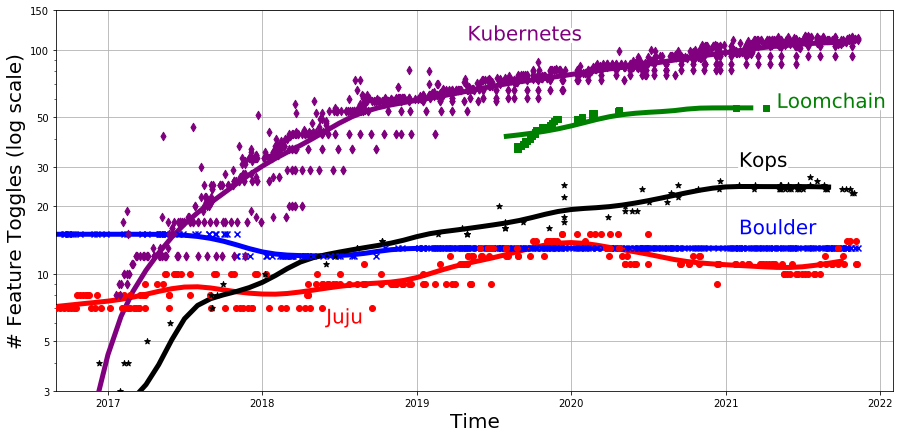

In [20]:
fig, ax = plt.subplots(figsize=((15, 7)))

plt.xlim(datetime.date(2016, 9, 1), datetime.date(2022, 2, 1))
plt.ylim(3, 100)

ax.grid(zorder = 0)

colors = ['blue', 'red', 'black', 'purple', 'green', 'grey']
markers = ["x", "o", "*", "d", "s"]

dates = [datetime.date(2021, 2, 1), datetime.date(2018, 6, 1), datetime.date(2021, 2, 1), datetime.date(2019, 5, 1), datetime.date(2021, 5, 1)]
vals = [15, 6, 30, 110, 55]

handles, labels = ax.get_legend_handles_labels()

keys = [k for k in res.keys()]

p = []

for i in range(len(keys)):
    sys = keys[i]
    sys_name = sys[0].upper()+sys[1:]
    df = get_estimation(sys)
    ax.scatter(res[sys].date, res[sys].ft, color = colors[i], marker= markers[i], zorder = 4),
    ax.plot(df.date, df.est, color = colors[i], linewidth = 5, label = sys)
    p.append(mlines.Line2D([], [], color=colors[i], 
                           marker= markers[i], markersize=10, linewidth = 5, label=sys_name))
    ax.text(dates[i], vals[i], sys_name, color = colors[i], size = 20, 
            path_effects=[pe.withStroke(linewidth=6, foreground="white")])

#ax.legend(handles=p)
ax.set_yscale('log')
ax.get_yaxis().set_major_formatter(ScalarFormatter())
ax.set_yticks([3, 5, 10, 20, 30, 50,100, 150])
plt.ylabel("# Feature Toggles (log scale)", size = 20)
plt.xlabel("Time", size = 20)
plt.savefig("./results/evolution_fts2.png", dpi = 300)
plt.show()